### The aim of this analysis is to classify standards in unsupervised way

Alternative to custom classification based on the knowledge of chemistry is clustering-based classification.

Here we try 3 approaches:
1. Classification based on Morgan fingerprint similarity
2. Classification based on HMDB functional group similarity
3. Classification based on HMDB physiochemical properties (some properties are predicted)

### Morgan fingerprint similarity

Morgan fingerprints are calculated in RDkit

In [1]:
import pandas as pd
from pathlib import Path
from definitions import ROOT_DIR
from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import AllChem, PandasTools, Draw
from matplotlib import animation
from anndata import AnnData
import scanpy as sc
import numpy as np

In [2]:
p_root_dir = Path(r"D:\saharuka\spotting\20_matrices")
p_analysis = p_root_dir / r"5_data_analysis/alternative_classification"
p_hmdb_smiles = p_analysis / "hmdb_smiles_2020-09-09.csv"
p_compounds = p_root_dir / "5_data_analysis" / "compounds_ids.csv"
p_out = p_root_dir / "5_data_analysis" / "alternative_classification.csv"

In [3]:
# Map smiles to compounds
smiles = pd.read_csv(p_hmdb_smiles)
compounds = pd.read_csv(p_compounds)
compound_smiles = pd.merge(compounds[['internal_id', 'name_short', 'hmdb_primary', 'is_hmdbid_matching']], smiles, on='hmdb_primary', how='left')

# Remove thermometers from standard list
df = compound_smiles.loc[~(compound_smiles.hmdb_primary == 'custom')]

In [4]:
# Check for invalid smiles
c_smiles = []
# for ds in ['COH', 'C=O', 'C(O)']: #test
for ds in df.smiles:
    try:
        cs = Chem.CanonSmiles(ds)
        c_smiles.append(cs)
    except:
        print('Invalid SMILES:', ds)

In [5]:
# Convert smiles to mol, calculate Morgan fingerprints
PandasTools.AddMoleculeColumnToFrame(df,'smiles','mol',includeFingerprints=True)

# Calculate fingerprints
fps = []
bis = []

for i, mol in enumerate(df.mol):
    
    bi = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 1, 2048, bitInfo = bi) # radius=2, nbits = 1024
    
    fps.append(fp)
    bis.append(bi)
    
    bi=None
    
df['fp'] = fps # what you write into df is not the same
df['bi'] = bis

C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\rdkit\Chem\PandasTools.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(
<ipython-input-5-dee0ae678fa3>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fp'] = fps # what you write into df is not the same
<ipython-input-5-dee0ae678fa3>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [6]:
# Make anndata with Morgan fingerprint matrix
fp_data = [list(x) for x in df.fp]
fp_df = pd.DataFrame(fp_data, index = df.internal_id)

adf = AnnData(fp_df, dtype='bool')
adf.obs['mol'] = df.mol.values
adf.obs['name_short'] = df.name_short.values

# Remove fingerprints that are not in any molecule
sc.pp.filter_genes(adf, min_cells=1)

C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\anndata\_core\anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


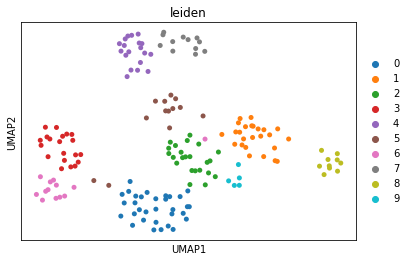

In [7]:
# Peform UMAP and clustering
sc.pp.neighbors(adf, n_neighbors=10, metric='jaccard', use_rep='X')

sc.tl.umap(adf, min_dist=0.5, spread=1.0)
sc.tl.leiden(adf, resolution=1.5)
sc.pl.umap(adf, size=100, color='leiden')

C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


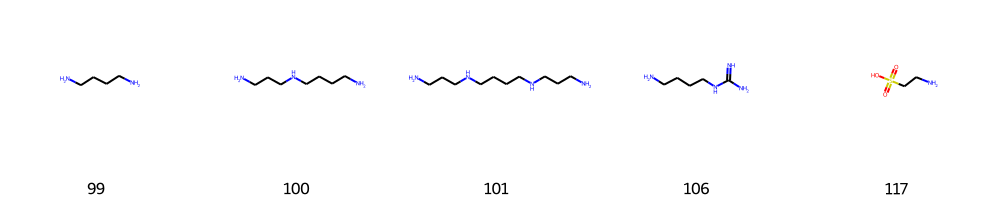

In [8]:
# Visually inspect and name clusters
cluster = '9'
mols = adf[adf.obs.leiden == cluster].obs.mol.values
titles = [str(x) for x in adf[adf.obs.leiden == cluster].obs.index]
    
Draw.MolsToGridImage(mols, molsPerRow=5, legends = titles)

In [9]:
morgan_classes = dict({
    '0':'aromatics',
    '1':'carboxylic acids',
    '2':'amino acids and peptides',
    '3':'cyclic carbohydrates',
    '4':'lipids',
    '5':'linear carbohydrates',
    '6':'nucleo*ides',
    '7':'4o amines',
    '8':'steriods',
    '9':'amines'
})

# Record classes in result dataframe
alt_class = pd.DataFrame([])
alt_class['internal_id'] = df.internal_id.values
alt_class['name_short'] = df.name_short.values
alt_class['morgan_class'] = [morgan_classes[x] for x in adf.obs.leiden]

### Functional group similarity 

Functional groups are taken from HMDB

In [10]:
# Map functional groups to compounds
p_functional = p_analysis / r"hmdb_substituents_2020-09-09.csv"

functional = pd.read_csv(p_functional)
df2 = pd.merge(df, functional, on='hmdb_primary', how='left')

# Methionine, adenine and folic acid have no functional group entry in HMDB, skip them
df2.substituents.replace('[]', '["Not defined"]', inplace=True)

In [11]:
# Make anndata with functional group matrix
fg_df = pd.DataFrame([])
for i in df2.iterrows():
    for j in eval(i[1].substituents):
        fg_df.loc[i[0], j] = 1
        
fg_df.replace(np.nan, 0, inplace=True)

adf = AnnData(fg_df, dtype='bool')
adf.obs['name_short'] = df2.name_short.values
adf.obs['mol'] = df2.mol.values

C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\anndata\_core\anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


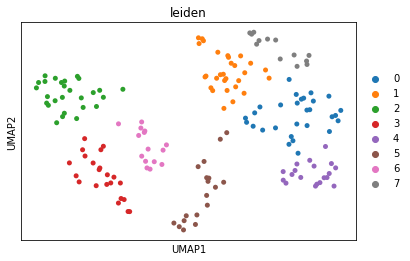

In [12]:
# Peform UMAP and clustering
sc.pp.neighbors(adf, n_neighbors=10, metric='jaccard', use_rep='X')
sc.tl.umap(adf, min_dist=0.3, spread=1.0)
sc.tl.leiden(adf, resolution=1)
sc.pl.umap(adf, size=100, color='leiden')

In [13]:
# cluster = '1'
# mols = adf[adf.obs.leiden == cluster].obs.mol.values
# titles = [str(x) for x in adf[adf.obs.leiden == cluster].obs.index]
    
# Draw.MolsToGridImage(mols, molsPerRow=5, legends = titles)

# Some clusters same as Morgan clusetrs, other don't make sense 

In [14]:
# Add to results datafarme
alt_class['hmdb_func_group_class'] = adf.obs.leiden.values

### Similarity of chemical properties

Properties are taken from HMDB

In [15]:
# Map metadata to compounds
p_donor_acceptor = p_analysis / "hmdb_donor_acceptor_2020-09-09.csv"
p_solubility = p_analysis / "hmdb_solubility_2020-09-09.csv"
p_polar = p_analysis / "hmdb_polar_2020-09-09.csv"
p_pka = p_analysis / "hmdb_pka_2020-09-09.csv"

donor_acceptor = pd.read_csv(p_donor_acceptor)
solubility =  pd.read_csv(p_solubility)
polar =  pd.read_csv(p_polar)
pka =  pd.read_csv(p_pka)

df3 = pd.merge(df, donor_acceptor, on='hmdb_primary', how='left')
df3 = pd.merge(df3, solubility, on='hmdb_primary', how='left')
df3 = pd.merge(df3, polar, on='hmdb_primary', how='left')
df3 = pd.merge(df3, pka, on='hmdb_primary', how='left')
# strong acid pka=0, weak acid pka=14
# strong base pka=0, weak base pka=14
df3.loc[:, ['pka_strongest_acidic']].replace(np.nan, 14, inplace=True) # if no value make is weakest acid
df3.loc[:, ['pka_strongest_basic']].replace(np.nan, 14, inplace=True) # if no value make it weakest base
df3.replace(np.nan, 0, inplace=True)

In [16]:
# Construct anndata with properties matrix

metadata = ['acceptor_count', 'donor_count', 'solubility', 'logp', 'logs', 'polar_surface_area',
       'polarizability', 'pka_strongest_acidic', 'pka_strongest_basic']

adf = AnnData(df3.loc[:, metadata])
adf.obs['name_short'] = df3.name_short.values
adf.obs['mol'] = df3.mol.values

C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\anndata\_core\anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


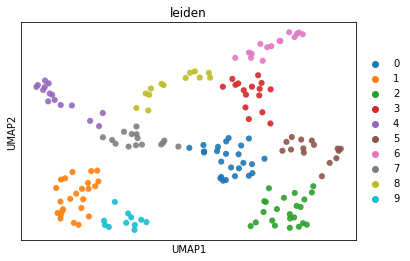

In [17]:
# Perform UMAP and clustering
sc.pp.scale(adf)
sc.pp.neighbors(adf, n_neighbors=10) #this time euclidean distance
sc.tl.umap(adf, min_dist=0.3, spread=1.0)
sc.tl.leiden(adf, resolution=1.5)
sc.pl.umap(adf, size=150, alpha=0.9, color='leiden')

C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


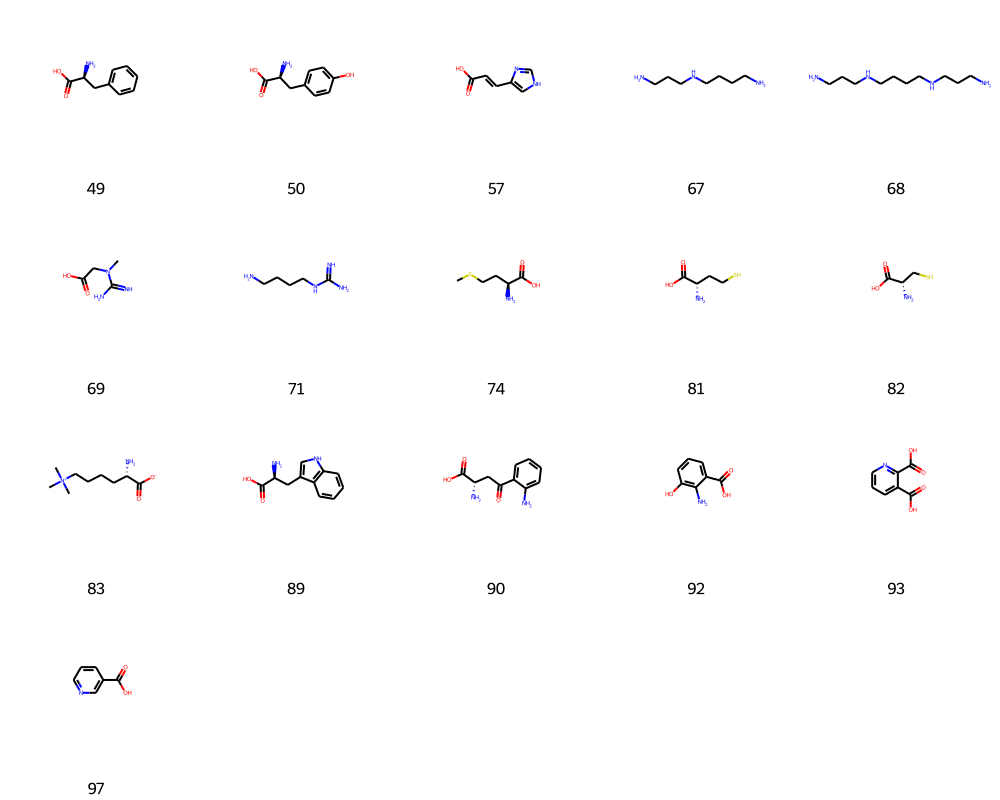

In [18]:
# Visually inspect and name clusters
cluster = '3'
mols = adf[adf.obs.leiden == cluster].obs.mol.values
titles = [str(x) for x in adf[adf.obs.leiden == cluster].obs.index]
    
Draw.MolsToGridImage(mols, molsPerRow=5, legends = titles)

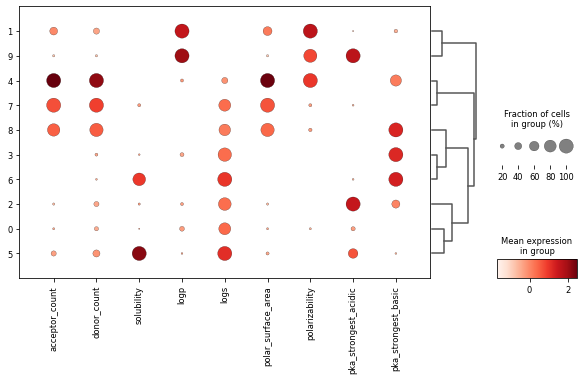

In [19]:
# This plot may help with cluster naming
sc.pl.dotplot(adf, adf.var.index, groupby='leiden', dendrogram=True, figsize=(10,5))

In [20]:
property_classes = dict({
    '0':'small strong amphoteric',
    '1':'amphoteric lipids',
    '2':'weak amphoteric',
    '3':'small basic',
    '4':'polar basic',
    '5':'acidic aqueous',
    '6':'basic aqueous',
    '7':'large strong amphoteric',
    '8':'large basic',
    '9':'acidic lipids'
})

In [22]:
alt_class.head()

,internal_id,name_short,morgan_class,hmdb_func_group_class,property_class
0,0,D-Glucose,cyclic carbohydrates,5,acidic aqueous
1,1,Glucose 6-phosphate,cyclic carbohydrates,5,large strong amphoteric
2,3,"Fructose 1,6-bisphosphate",cyclic carbohydrates,5,large strong amphoteric
3,4,Dihydroxyacetone phosphate,linear carbohydrates,3,small strong amphoteric
4,7,3-Phosphoglyceric acid,linear carbohydrates,3,small strong amphoteric


In [21]:
# Save classification into results
alt_class['property_class'] = [property_classes[x] for x in adf.obs.leiden]
alt_class.to_csv(p_out, index=False)